In [ ]:
!pip install tensorflow

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

keypoints using MEDIAPIPE HOLISTICS

In [2]:
mpHolistics = mp.solutions.holistic # mediapipe holistics model
mpDrawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipeDetection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # as openCV take BGR therefore we convert it to RGB
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # we reverse it back from RGB to BGR
    return image, results

In [4]:
def drawLandmark(image, results):
    mpDrawing.draw_landmarks(image, results.face_landmarks, mpHolistics.FACEMESH_CONTOURS) # Draw face connections 
    mpDrawing.draw_landmarks(image, results.pose_landmarks, mpHolistics.POSE_CONNECTIONS) # Draw pose connections 
    mpDrawing.draw_landmarks(image, results.left_hand_landmarks, mpHolistics.HAND_CONNECTIONS) # Draw left hand connections 
    mpDrawing.draw_landmarks(image, results.right_hand_landmarks, mpHolistics.HAND_CONNECTIONS) # Draw right hand connections 

In [5]:
def drawStyleLandmark(image, results):
    mpDrawing.draw_landmarks(image, results.face_landmarks, mpHolistics.FACEMESH_CONTOURS,
                            mpDrawing.DrawingSpec(color = (80,110,10), thickness=1, circle_radius=1),
                            mpDrawing.DrawingSpec(color = (80,110,10), thickness=1, circle_radius=1)
                            ) # Draw face connections 
    mpDrawing.draw_landmarks(image, results.pose_landmarks, mpHolistics.POSE_CONNECTIONS,
                            mpDrawing.DrawingSpec(color = (80,22,10), thickness=2, circle_radius=4),
                            mpDrawing.DrawingSpec(color = (80,44,121), thickness=2, circle_radius=2)
                            ) # Draw pose connections 
    mpDrawing.draw_landmarks(image, results.left_hand_landmarks, mpHolistics.HAND_CONNECTIONS,
                            mpDrawing.DrawingSpec(color = (121,22,76), thickness=2, circle_radius=4),
                            mpDrawing.DrawingSpec(color = (121,44,250), thickness=2, circle_radius=2)
                            ) # Draw left hand connections 
    mpDrawing.draw_landmarks(image, results.right_hand_landmarks, mpHolistics.HAND_CONNECTIONS,
                            mpDrawing.DrawingSpec(color = (121,22,76), thickness=2, circle_radius=4),
                            mpDrawing.DrawingSpec(color = (121,44,250), thickness=2, circle_radius=2)
                            ) # Draw right hand connections 

In [6]:
def changeResolution():
    camera.set(3,2560)
    camera.set(4,1440)

In [7]:
camera = cv2.VideoCapture(0)
changeResolution()
with mpHolistics.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5,) as holistics:
    while camera.isOpened():
        ret, frame = camera.read() # reads the frame
        
        #make mediapipe holistic detection
        image, results = mediapipeDetection(frame, holistics)
#         print(results)
        
        #print landmark on live feed
        drawStyleLandmark(image, results)
        
        cv2.imshow('OpenCV Feed', image) # output the frames

        # Break the loop or camera
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    camera.release()
    cv2.destroyAllWindows()

In [8]:
# len(results.left_hand_landmarks.landmark)

In [9]:
# frame
results

mediapipe.python.solution_base.SolutionOutputs

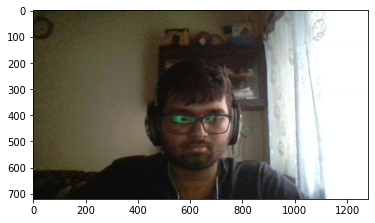

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


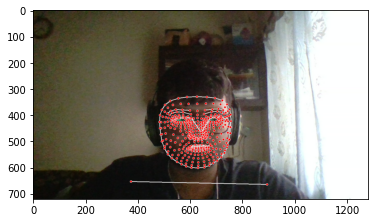

In [11]:
drawLandmark(frame, results)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Extract Keypoint Values

In [12]:
len(results.pose_landmarks.landmark)

33

In [13]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [14]:
len(pose)

33

In [15]:
def extractKeypointsArray(results):
    # extracting keypoints from face, pose, lefthand and righthand and storing them in form of numpy arrays
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    leftHand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rightHand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, leftHand, rightHand])

In [16]:
# face.shape

In [17]:
# pose.shape

In [18]:
# leftHand.shape

In [19]:
# rightHand.shape

In [20]:
# extractKeypointsArray(results).shape

In [21]:
# 1404+132+63+63

Setteing up Folder for data collection

In [22]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('signLanguageDataset') 

# Actions that we try to detect
actions = np.array(['A','Access','Accident','Add','Additional','Address','Afternoon',
                    'Age','Agree','All','Hello','Hi','Language','Myself','our','present','Sign','thank you',
                   'we','you'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [23]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

Collecting Keypoint values for training and testing

In [ ]:
cap = cv2.VideoCapture(0)
changeResolution()
# Set mediapipe model 
with mpHolistics.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipeDetection(frame, holistic)
#                 print(results)

                # Draw landmarks
                drawStyleLandmark(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extractKeypointsArray(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

Pre-processing the DATA

In [24]:
 pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\shree\appdata\local\programs\python\python39\lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [26]:
labelMap = {label:num for num, label in enumerate(actions)}

In [27]:
labelMap

{'A': 0,
 'Access': 1,
 'Accident': 2,
 'Add': 3,
 'Additional': 4,
 'Address': 5,
 'Afternoon': 6,
 'Age': 7,
 'Agree': 8,
 'All': 9,
 'Hello': 10,
 'Hi': 11,
 'Language': 12,
 'Myself': 13,
 'our': 14,
 'present': 15,
 'Sign': 16,
 'thank you': 17,
 'we': 18,
 'you': 19}

In [28]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(labelMap[action])

In [29]:
np.array(sequences).shape

(600, 30, 1662)

In [30]:
np.array(labels).shape

(600,)

In [31]:
X = np.array(sequences)

In [32]:
X.shape

(600, 30, 1662)

In [33]:
y = to_categorical(labels).astype(int)

In [34]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [36]:
X_train.shape

(570, 30, 1662)

In [37]:
y_test.shape

(30, 20)

LSTM main Building process

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [39]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [40]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [41]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=160, callbacks=[tb_callback])

In [42]:
model.load_weights('action.h5')

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 20)                660       
                                                                 
Total params: 597,236
Trainable params: 597,236
Non-trai

In [44]:
res = model.predict(X_test)

1/1 [==============================] - 1s 539ms/step


In [45]:
actions[np.argmax(res[12])]

'Address'

In [46]:
actions[np.argmax(y_test[12])]

'Address'

In [ ]:
model.save('action.h5')

In [ ]:
# del model

In [ ]:
model.load_weights('action.h5')

Evaluation with confusion matrix and accuracy

In [47]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [48]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 46ms/step


In [49]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [50]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[29,  0],
        [ 0,  1]],

       [[28,  0],
        [ 0,  2]],

       [[28,  0],
        [ 0,  2]],

       [[25,  0],
        [ 0,  5]],

       [[28,  0],
        [ 0,  2]],

       [[29,  0],
        [ 0,  1]],

       [[29,  0],
        [ 0,  1]],

       [[29,  0],
        [ 0,  1]],

       [[28,  0],
        [ 0,  2]],

       [[29,  0],
        [ 0,  1]],

       [[29,  0],
        [ 0,  1]],

       [[28,  0],
        [ 0,  2]],

       [[29,  0],
        [ 0,  1]],

       [[27,  0],
        [ 0,  3]],

       [[27,  0],
        [ 0,  3]],

       [[28,  0],
        [ 0,  2]]], dtype=int64)

In [51]:
accuracy_score(ytrue, yhat)

1.0

Test in real time

In [52]:
# from scipy import stats

In [53]:
# colors = [(245,117,16), (117,245,16), (16,117,245)]
# def prob_viz(res, actions, input_frame, colors):
#     output_frame = input_frame.copy()
#     for num, prob in enumerate(res):
#         cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
#         cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
#     return output_frame

In [54]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res, actions, image, colors))

In [71]:
sequence = []
sentence = []
predictions = []
threshold = 0.3
changeResolution()

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mpHolistics.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipeDetection(frame, holistic)
        print(results)
        
        # Draw landmarks
        drawStyleLandmark(image, results)
        
        # 2. Prediction logic
        keypoints = extractKeypointsArray(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
#             predictions.append(np.argmax(res))
            
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] not in sentence:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 21ms/step
Hi
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thank you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thank you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
thank you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thank you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thank you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
thank you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
thank you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
tha

1/1 [==============================] - 0s 20ms/step
you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
you
<class 'mediapipe.python.solution_base.S

In [60]:
cap.release()
cv2.destroyAllWindows()

In [65]:
type(res)

numpy.ndarray

In [66]:
res.shape

(20,)

In [67]:
model.predict(X_test)

1/1 [==============================] - 0s 48ms/step


array([[9.97569859e-01, 1.59323648e-08, 3.88073532e-11, 1.34707676e-10,
        1.36387001e-15, 5.00172177e-07, 4.93114257e-14, 1.62481779e-12,
        6.16566409e-10, 5.98489184e-12, 2.15897453e-05, 1.22651007e-04,
        1.27062172e-04, 7.66315586e-14, 5.84953405e-11, 7.43048956e-10,
        1.72210548e-05, 1.03417225e-03, 1.17336567e-08, 1.10687967e-03],
       [2.77599818e-12, 1.15470326e-20, 4.01583111e-16, 7.49015502e-11,
        6.66669730e-19, 1.87163609e-12, 1.98214643e-12, 1.79569727e-11,
        8.32909384e-14, 2.12074418e-16, 2.59189937e-06, 4.13143833e-04,
        1.83872140e-09, 2.38640814e-06, 3.78757026e-09, 6.47074515e-16,
        9.06942837e-12, 9.99391198e-01, 3.93067329e-10, 1.90656123e-04],
       [4.32664848e-07, 4.91517105e-10, 3.60986701e-06, 4.39381687e-08,
        1.67434806e-07, 2.26994934e-09, 6.77944056e-09, 5.59033870e-05,
        2.51967514e-08, 1.25900668e-03, 3.59187453e-07, 1.17658863e-04,
        1.89160914e-06, 2.25179588e-06, 9.97990489e-01, 1.2836

In [ ]:
res

In [ ]:
np.expand_dims(X_test[0], axis=0).shape

In [ ]:
# print(actions[np.argmax(res)])

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))

In [ ]:
np.expand_dims(X_test[0], axis=0)